In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def exact_solution(d, w0, t):
    """
    Defines the analytical solution to the under-damped harmonic oscillator problem.
    """
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = exp * 2 * A * cos
    return u

class FCN(nn.Module):
    """
    Defines a standard fully-connected network in pytorch
    """
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS - 1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

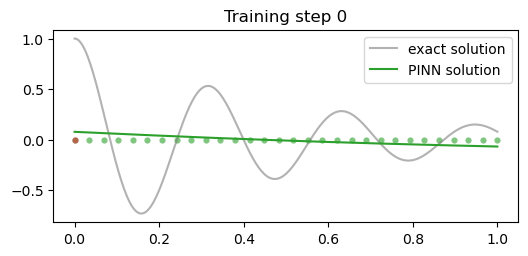

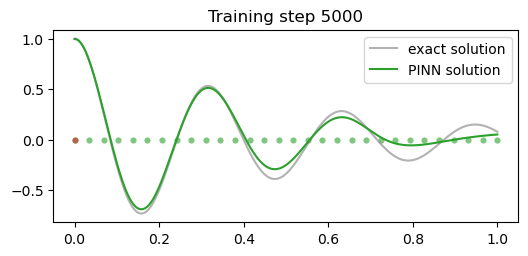

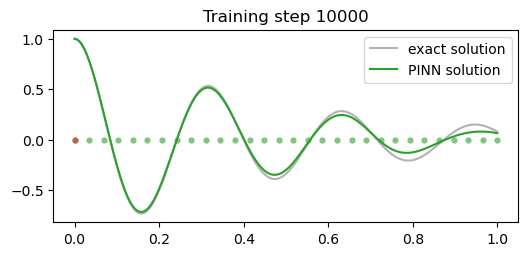

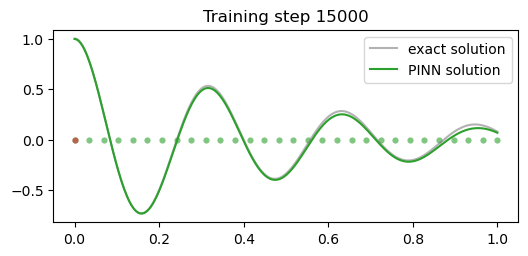

In [5]:
torch.manual_seed(123)
pinn = FCN(1, 1, 32, 3)

# boundary points for the boundary loss
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# train the pinn
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()
    lambda1, lambda2 = 1e-1, 1e-4

    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u)-1)**2

    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt)-0)**2

    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_physics.detach()[:, 0], torch.zeros_like(t_physics)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:, 0], torch.zeros_like(t_boundary)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:, 0], u_exact[:, 0], label="exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()